In [1]:
text = sc.wholeTextFiles('Geolife Trajectories 1.3/Data/10*/*')

In [2]:
data = text.flatMap(lambda x:x[1].split('\r\n')[6:])\
                   .map(lambda x:x.split(','))\
                   .filter(lambda x:len(x) == 7)

data.take(2)

[['39.974408918',
  '116.303522101',
  '0',
  '480.287355643045',
  '40753.5306944444',
  '2011-07-29',
  '12:44:12'],
 ['39.974397078',
  '116.303526932',
  '0',
  '480.121151574803',
  '40753.5307060185',
  '2011-07-29',
  '12:44:13']]

In [3]:
header = ['Latitude', 'Longitude', 'Altitude in feet', 'Date', 'Time']

df = data.map(lambda x:[float(x[0]), float(x[1]), float(x[3]), x[5], x[6]]).toDF(header)

df.printSchema()
df.show()
print(df.count(), 'Data points')

root
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Altitude in feet: double (nullable = true)
 |-- Date: string (nullable = true)
 |-- Time: string (nullable = true)

+------------+-------------+----------------+----------+--------+
|    Latitude|    Longitude|Altitude in feet|      Date|    Time|
+------------+-------------+----------------+----------+--------+
|39.974408918|116.303522101|480.287355643045|2011-07-29|12:44:12|
|39.974397078|116.303526932|480.121151574803|2011-07-29|12:44:13|
|39.973982524|116.303621837|478.499455380577|2011-07-29|12:44:15|
|39.973943291|116.303632641|479.176988188976|2011-07-29|12:44:16|
|39.973937148|116.303639667|479.129432414698|2011-07-29|12:44:17|
|39.973916715| 116.30363848|479.615278871391|2011-07-29|12:44:18|
|39.973892264|116.303644867|480.506026902887|2011-07-29|12:44:19|
|39.973867401|116.303647142| 481.38750984252|2011-07-29|12:44:20|
|39.973836462| 116.30365019|482.008727034121|2011-07-29|12:44:21|
|

In [4]:
position_data_x = df.select('Latitude').rdd.flatMap(lambda x:list(x)).cache()
position_data_y = df.select('Longitude').rdd.flatMap(lambda x:list(x)).cache()

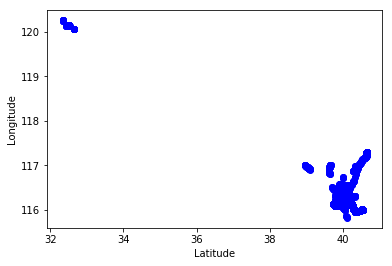

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(position_data_x.collect(), position_data_y.collect(), 'ob')
plt.xlabel('Latitude') 
plt.ylabel('Longitude')
plt.show()